In [1]:
from os import listdir
from os.path import join

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from butadien.load_data import load_data
from SCFInitialGuess.utilities.dataset import Dataset
dim = 26
model_save_path = "butadien/model.npy"

source = "./butadien/data"
dataset = Dataset(*load_data(source)) 

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [3]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import train_network

structure = [dim**2, 200, 100, dim**2]

network, sess = train_network(
    EluTrNNN(structure),
    dataset,
    evaluation_period=100,
    mini_batch_size=20,
    convergence_threshold=1e-6
)

network.export(sess, model_save_path)

[-] 2018-03-08 17:15:44: Setting up the graph ...
[-] 2018-03-08 17:15:46: Starting network training ...
[ ] 2018-03-08 17:15:46: Validation cost: 1.45004E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-08 17:15:47: Validation cost: 1.74437E-04. Diff to prev.: 1.4E-02
[ ] 2018-03-08 17:15:47: Validation cost: 2.10931E-04. Diff to prev.: 3.6E-05
[ ] 2018-03-08 17:15:48: Validation cost: 1.84696E-04. Diff to prev.: 2.6E-05
[ ] 2018-03-08 17:15:48: Validation cost: 1.41103E-04. Diff to prev.: 4.4E-05
[ ] 2018-03-08 17:15:49: Validation cost: 1.54037E-04. Diff to prev.: 1.3E-05
[ ] 2018-03-08 17:15:49: Validation cost: 1.19561E-04. Diff to prev.: 3.4E-05
[ ] 2018-03-08 17:15:50: Validation cost: 1.20881E-04. Diff to prev.: 1.3E-06
[ ] 2018-03-08 17:15:50: Validation cost: 1.17445E-04. Diff to prev.: 3.4E-06
[-] 2018-03-08 17:15:51: Convergence reached after 900 steps.
[-] 2018-03-08 17:15:51: Test error: 1.13940E-04


In [4]:
np.diag(dataset.testing[1][1].reshape((26,26)))

array([ 1.0360511,  0.3952665,  0.3148447,  0.3135968,  0.4232927,
        1.036366 ,  0.4479182,  0.3095481,  0.3044367,  0.369791 ,
        1.0357658,  0.4007037,  0.304312 ,  0.3167303,  0.3813417,
        1.0356569,  0.3850345,  0.3035735,  0.3206757,  0.4045734,
        0.286106 ,  0.2795064,  0.3194618,  0.3080602,  0.2907742,
        0.307579 ])

# Analysis

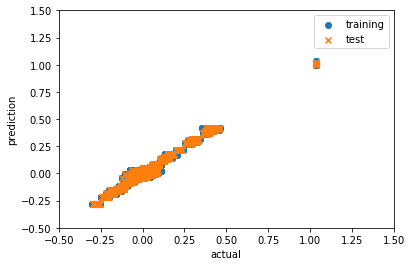

In [5]:
flatten = lambda x, y: list(x) + list(y)


#training
expected = reduce(flatten, dataset.training[1])
actual = reduce(flatten, 
    network.run(
        sess, 
        dataset.training[0]
    )
)

frac  = 1
index = np.arange(int(np.floor(frac * len(actual))))
np.random.shuffle(index)
plt.scatter(np.array(expected)[index], np.array(actual)[index], label="training")

# test dataset
expected = reduce(flatten, dataset.testing[1])
actual = reduce(flatten, 
    network.run(
        sess, 
        dataset.testing[0]
    )
)
plt.scatter(expected,actual, marker="x", label="test")

plt.legend()

lower, upper = -0.5, 1.5
plt.axis([lower, upper, lower, upper])
plt.ylabel("prediction")
plt.xlabel("actual")
plt.show()

## Benchmarking the guess 
SCF runs for inputs in ./data with py scf, statistik mit anzahl der iterations

plot wie oben nur noch mit den density matrix werten von pyscf initialguesses (e.g. 1 für geuessbyminao, 1 für atomicdesity etc.)
x -> expected
y -> (network prediction training, network prediction test, pyscf initialguess werte für jeweiliges atom )

### Fetching the molecules

In [6]:
from os import listdir
from os.path import join

from SCFInitialGuess.utilities import Molecule

def grep_molecule(input_file):
    import re
    
    with open(input_file) as f:
            
        molecule = re.search(r"\$molecule.*\$end", f.read(), re.DOTALL)
        if molecule is None:
            raise ValueError("No molecule found in " + f.name)
        else:
            molecule = molecule.group(0)

            # cut out geometries
            geometries = molecule.splitlines()[2:-1]

    # from geometries take the species and positions
    species, positions = [], []
    for line in geometries:
        splits = line.split()
        species.append(splits[0])
        positions.append(splits[1:])

    return species, positions

def fetch_molecules(folder):
    
    files = [file for file in listdir(folder) if ".inp" in file]
    
    for i, file in enumerate(files):
        
        print("Fetching: " + str(i + 1) + "/" + str(len(files)))

        mol = Molecule(*grep_molecule(join(folder, file)))
        
        mol.basis = "sto-3g"
        
        yield mol
        
        
molecules = list(fetch_molecules("butadien/data"))

Fetching: 1/200
Fetching: 2/200
Fetching: 3/200
Fetching: 4/200
Fetching: 5/200
Fetching: 6/200
Fetching: 7/200
Fetching: 8/200
Fetching: 9/200
Fetching: 10/200
Fetching: 11/200
Fetching: 12/200
Fetching: 13/200
Fetching: 14/200
Fetching: 15/200
Fetching: 16/200
Fetching: 17/200
Fetching: 18/200
Fetching: 19/200
Fetching: 20/200
Fetching: 21/200
Fetching: 22/200
Fetching: 23/200
Fetching: 24/200
Fetching: 25/200
Fetching: 26/200
Fetching: 27/200
Fetching: 28/200
Fetching: 29/200
Fetching: 30/200
Fetching: 31/200
Fetching: 32/200
Fetching: 33/200
Fetching: 34/200
Fetching: 35/200
Fetching: 36/200
Fetching: 37/200
Fetching: 38/200
Fetching: 39/200
Fetching: 40/200
Fetching: 41/200
Fetching: 42/200
Fetching: 43/200
Fetching: 44/200
Fetching: 45/200
Fetching: 46/200
Fetching: 47/200
Fetching: 48/200
Fetching: 49/200
Fetching: 50/200
Fetching: 51/200
Fetching: 52/200
Fetching: 53/200
Fetching: 54/200
Fetching: 55/200
Fetching: 56/200
Fetching: 57/200
Fetching: 58/200
Fetching: 59/200
Fetchi

### Doing the calculations

In [7]:
from pyscf.scf import hf

dim = 26

iterations = []
for i, molecule in enumerate(molecules):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/200.")
    
    # assemble pyscf initial guesses
    P_1e = hf.init_guess_by_1e(mol)
    P_atom = hf.init_guess_by_atom(mol)
    P_minao = hf.init_guess_by_minao(mol)
    
    # nn guess
    S = hf.get_ovlp(mol).reshape(1, dim**2)
    P_NN = network.run(sess, S).reshape(dim, dim).astype('float64')
    
    iterations_molecule = []
    for guess in [P_1e, P_atom, P_minao, P_NN]:
        
        mf = hf.RHF(mol)
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations.append(iterations_molecule)

iterations = np.array(iterations)

h5py-2.2.1 is found in your environment. h5py-2.2.1 has bug in threading mode.
Async-IO is disabled.
Warn: Ipython shell catchs sys.args


Calculating: 1/200.
Calculating: 2/200.


Warn: Ipython shell catchs sys.args


Calculating: 3/200.


Warn: Ipython shell catchs sys.args


Calculating: 4/200.


Warn: Ipython shell catchs sys.args


Calculating: 5/200.


Warn: Ipython shell catchs sys.args


Calculating: 6/200.


Warn: Ipython shell catchs sys.args


Calculating: 7/200.


Warn: Ipython shell catchs sys.args


Calculating: 8/200.


Warn: Ipython shell catchs sys.args


Calculating: 9/200.


Warn: Ipython shell catchs sys.args


Calculating: 10/200.


Warn: Ipython shell catchs sys.args


Calculating: 11/200.


Warn: Ipython shell catchs sys.args


Calculating: 12/200.


Warn: Ipython shell catchs sys.args


Calculating: 13/200.


Warn: Ipython shell catchs sys.args


Calculating: 14/200.


Warn: Ipython shell catchs sys.args


Calculating: 15/200.


Warn: Ipython shell catchs sys.args


Calculating: 16/200.


Warn: Ipython shell catchs sys.args


Calculating: 17/200.


Warn: Ipython shell catchs sys.args


Calculating: 18/200.


Warn: Ipython shell catchs sys.args


Calculating: 19/200.


Warn: Ipython shell catchs sys.args


Calculating: 20/200.


Warn: Ipython shell catchs sys.args


Calculating: 21/200.


Warn: Ipython shell catchs sys.args


Calculating: 22/200.


Warn: Ipython shell catchs sys.args


Calculating: 23/200.


Warn: Ipython shell catchs sys.args


Calculating: 24/200.


Warn: Ipython shell catchs sys.args


Calculating: 25/200.


Warn: Ipython shell catchs sys.args


Calculating: 26/200.


Warn: Ipython shell catchs sys.args


Calculating: 27/200.


Warn: Ipython shell catchs sys.args


Calculating: 28/200.


Warn: Ipython shell catchs sys.args


Calculating: 29/200.


Warn: Ipython shell catchs sys.args


Calculating: 30/200.


Warn: Ipython shell catchs sys.args


Calculating: 31/200.


Warn: Ipython shell catchs sys.args


Calculating: 32/200.


Warn: Ipython shell catchs sys.args


Calculating: 33/200.


Warn: Ipython shell catchs sys.args


Calculating: 34/200.


Warn: Ipython shell catchs sys.args


Calculating: 35/200.


Warn: Ipython shell catchs sys.args


Calculating: 36/200.


Warn: Ipython shell catchs sys.args


Calculating: 37/200.


Warn: Ipython shell catchs sys.args


Calculating: 38/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 39/200.


Warn: Ipython shell catchs sys.args


Calculating: 40/200.


Warn: Ipython shell catchs sys.args


Calculating: 41/200.
Calculating: 42/200.


Warn: Ipython shell catchs sys.args


Calculating: 43/200.


Warn: Ipython shell catchs sys.args


Calculating: 44/200.


Warn: Ipython shell catchs sys.args


Calculating: 45/200.


Warn: Ipython shell catchs sys.args


Calculating: 46/200.


Warn: Ipython shell catchs sys.args


Calculating: 47/200.


Warn: Ipython shell catchs sys.args


Calculating: 48/200.


Warn: Ipython shell catchs sys.args


Calculating: 49/200.


Warn: Ipython shell catchs sys.args


Calculating: 50/200.


Warn: Ipython shell catchs sys.args


Calculating: 51/200.


Warn: Ipython shell catchs sys.args


Calculating: 52/200.


Warn: Ipython shell catchs sys.args


Calculating: 53/200.


Warn: Ipython shell catchs sys.args


Calculating: 54/200.


Warn: Ipython shell catchs sys.args


Calculating: 55/200.


Warn: Ipython shell catchs sys.args


Calculating: 56/200.


Warn: Ipython shell catchs sys.args


Calculating: 57/200.


Warn: Ipython shell catchs sys.args


Calculating: 58/200.


Warn: Ipython shell catchs sys.args


Calculating: 59/200.


Warn: Ipython shell catchs sys.args


Calculating: 60/200.


Warn: Ipython shell catchs sys.args


Calculating: 61/200.


Warn: Ipython shell catchs sys.args


Calculating: 62/200.


Warn: Ipython shell catchs sys.args


Calculating: 63/200.


Warn: Ipython shell catchs sys.args


Calculating: 64/200.


Warn: Ipython shell catchs sys.args


Calculating: 65/200.


Warn: Ipython shell catchs sys.args


Calculating: 66/200.


Warn: Ipython shell catchs sys.args


Calculating: 67/200.


Warn: Ipython shell catchs sys.args


Calculating: 68/200.


Warn: Ipython shell catchs sys.args


Calculating: 69/200.


Warn: Ipython shell catchs sys.args


Calculating: 70/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 71/200.
Calculating: 72/200.


Warn: Ipython shell catchs sys.args


Calculating: 73/200.


Warn: Ipython shell catchs sys.args


Calculating: 74/200.


Warn: Ipython shell catchs sys.args


Calculating: 75/200.


Warn: Ipython shell catchs sys.args


Calculating: 76/200.


Warn: Ipython shell catchs sys.args


Calculating: 77/200.


Warn: Ipython shell catchs sys.args


Calculating: 78/200.


Warn: Ipython shell catchs sys.args


Calculating: 79/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 80/200.
Calculating: 81/200.


Warn: Ipython shell catchs sys.args


Calculating: 82/200.


Warn: Ipython shell catchs sys.args


Calculating: 83/200.


Warn: Ipython shell catchs sys.args


Calculating: 84/200.


Warn: Ipython shell catchs sys.args


Calculating: 85/200.


Warn: Ipython shell catchs sys.args


Calculating: 86/200.


Warn: Ipython shell catchs sys.args


Calculating: 87/200.


Warn: Ipython shell catchs sys.args


Calculating: 88/200.


Warn: Ipython shell catchs sys.args


Calculating: 89/200.


Warn: Ipython shell catchs sys.args


Calculating: 90/200.


Warn: Ipython shell catchs sys.args


Calculating: 91/200.


Warn: Ipython shell catchs sys.args


Calculating: 92/200.


Warn: Ipython shell catchs sys.args


Calculating: 93/200.


Warn: Ipython shell catchs sys.args


Calculating: 94/200.


Warn: Ipython shell catchs sys.args


Calculating: 95/200.


Warn: Ipython shell catchs sys.args


Calculating: 96/200.


Warn: Ipython shell catchs sys.args


Calculating: 97/200.


Warn: Ipython shell catchs sys.args


Calculating: 98/200.


Warn: Ipython shell catchs sys.args


Calculating: 99/200.


Warn: Ipython shell catchs sys.args


Calculating: 100/200.


Warn: Ipython shell catchs sys.args


Calculating: 101/200.


Warn: Ipython shell catchs sys.args


Calculating: 102/200.


Warn: Ipython shell catchs sys.args


Calculating: 103/200.


Warn: Ipython shell catchs sys.args


Calculating: 104/200.


Warn: Ipython shell catchs sys.args


Calculating: 105/200.


Warn: Ipython shell catchs sys.args


Calculating: 106/200.


Warn: Ipython shell catchs sys.args


Calculating: 107/200.


Warn: Ipython shell catchs sys.args


Calculating: 108/200.


Warn: Ipython shell catchs sys.args


Calculating: 109/200.


Warn: Ipython shell catchs sys.args


Calculating: 110/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 111/200.
Calculating: 112/200.


Warn: Ipython shell catchs sys.args


Calculating: 113/200.


Warn: Ipython shell catchs sys.args


Calculating: 114/200.


Warn: Ipython shell catchs sys.args


Calculating: 115/200.


Warn: Ipython shell catchs sys.args


Calculating: 116/200.


Warn: Ipython shell catchs sys.args


Calculating: 117/200.


Warn: Ipython shell catchs sys.args


Calculating: 118/200.


Warn: Ipython shell catchs sys.args


Calculating: 119/200.


Warn: Ipython shell catchs sys.args


Calculating: 120/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 121/200.


Warn: Ipython shell catchs sys.args


Calculating: 122/200.
Calculating: 123/200.


Warn: Ipython shell catchs sys.args


Calculating: 124/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 125/200.


Warn: Ipython shell catchs sys.args


Calculating: 126/200.
Calculating: 127/200.


Warn: Ipython shell catchs sys.args


Calculating: 128/200.


Warn: Ipython shell catchs sys.args


Calculating: 129/200.


Warn: Ipython shell catchs sys.args


Calculating: 130/200.


Warn: Ipython shell catchs sys.args


Calculating: 131/200.


Warn: Ipython shell catchs sys.args


Calculating: 132/200.


Warn: Ipython shell catchs sys.args


Calculating: 133/200.


Warn: Ipython shell catchs sys.args


Calculating: 134/200.


Warn: Ipython shell catchs sys.args


Calculating: 135/200.


Warn: Ipython shell catchs sys.args


Calculating: 136/200.


Warn: Ipython shell catchs sys.args


Calculating: 137/200.


Warn: Ipython shell catchs sys.args


Calculating: 138/200.


Warn: Ipython shell catchs sys.args


Calculating: 139/200.


Warn: Ipython shell catchs sys.args


Calculating: 140/200.


Warn: Ipython shell catchs sys.args


Calculating: 141/200.


Warn: Ipython shell catchs sys.args


Calculating: 142/200.


Warn: Ipython shell catchs sys.args


Calculating: 143/200.


Warn: Ipython shell catchs sys.args


Calculating: 144/200.


Warn: Ipython shell catchs sys.args


Calculating: 145/200.


Warn: Ipython shell catchs sys.args


Calculating: 146/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 147/200.
Calculating: 148/200.


Warn: Ipython shell catchs sys.args


Calculating: 149/200.


Warn: Ipython shell catchs sys.args


Calculating: 150/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 151/200.
Calculating: 152/200.


Warn: Ipython shell catchs sys.args


Calculating: 153/200.


Warn: Ipython shell catchs sys.args


Calculating: 154/200.


Warn: Ipython shell catchs sys.args


Calculating: 155/200.


Warn: Ipython shell catchs sys.args


Calculating: 156/200.


Warn: Ipython shell catchs sys.args


Calculating: 157/200.


Warn: Ipython shell catchs sys.args


Calculating: 158/200.


Warn: Ipython shell catchs sys.args


Calculating: 159/200.


Warn: Ipython shell catchs sys.args


Calculating: 160/200.


Warn: Ipython shell catchs sys.args


Calculating: 161/200.


Warn: Ipython shell catchs sys.args


Calculating: 162/200.


Warn: Ipython shell catchs sys.args


Calculating: 163/200.


Warn: Ipython shell catchs sys.args


Calculating: 164/200.


Warn: Ipython shell catchs sys.args


Calculating: 165/200.


Warn: Ipython shell catchs sys.args


Calculating: 166/200.


Warn: Ipython shell catchs sys.args


Calculating: 167/200.


Warn: Ipython shell catchs sys.args


Calculating: 168/200.


Warn: Ipython shell catchs sys.args


Calculating: 169/200.


Warn: Ipython shell catchs sys.args


Calculating: 170/200.


Warn: Ipython shell catchs sys.args


Calculating: 171/200.


Warn: Ipython shell catchs sys.args


Calculating: 172/200.


Warn: Ipython shell catchs sys.args


Calculating: 173/200.


Warn: Ipython shell catchs sys.args


Calculating: 174/200.


Warn: Ipython shell catchs sys.args


Calculating: 175/200.


Warn: Ipython shell catchs sys.args


Calculating: 176/200.


Warn: Ipython shell catchs sys.args


Calculating: 177/200.


Warn: Ipython shell catchs sys.args


Calculating: 178/200.


Warn: Ipython shell catchs sys.args


Calculating: 179/200.


Warn: Ipython shell catchs sys.args


Calculating: 180/200.


Warn: Ipython shell catchs sys.args


Calculating: 181/200.


Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args


Calculating: 182/200.
Calculating: 183/200.


Warn: Ipython shell catchs sys.args


Calculating: 184/200.


Warn: Ipython shell catchs sys.args


Calculating: 185/200.


Warn: Ipython shell catchs sys.args


Calculating: 186/200.


Warn: Ipython shell catchs sys.args


Calculating: 187/200.


Warn: Ipython shell catchs sys.args


Calculating: 188/200.


Warn: Ipython shell catchs sys.args


Calculating: 189/200.


Warn: Ipython shell catchs sys.args


Calculating: 190/200.


Warn: Ipython shell catchs sys.args


Calculating: 191/200.


Warn: Ipython shell catchs sys.args


Calculating: 192/200.


Warn: Ipython shell catchs sys.args


Calculating: 193/200.


Warn: Ipython shell catchs sys.args


Calculating: 194/200.


Warn: Ipython shell catchs sys.args


Calculating: 195/200.


Warn: Ipython shell catchs sys.args


Calculating: 196/200.


Warn: Ipython shell catchs sys.args


Calculating: 197/200.


Warn: Ipython shell catchs sys.args


Calculating: 198/200.


Warn: Ipython shell catchs sys.args


Calculating: 199/200.


Warn: Ipython shell catchs sys.args


Calculating: 200/200.


Warn: Ipython shell catchs sys.args


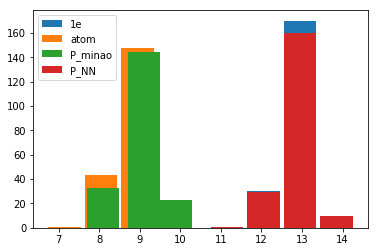

In [11]:
#fig, axes = plt.subplots(2,2)

bins = 20 # todo hier kann man auch ein array angeben

for i, name in enumerate(['1e', 'atom', 'P_minao', 'P_NN']):
    
    hist, bins = np.histogram(iterations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()
    
    


In [12]:
np.mean(iterations,0)

array([ 12.85 ,   8.815,   8.95 ,  12.895])